# Ruya Evaluation

In [1]:
import collections, warnings, pickle, pandas as pd
import matplotlib.pyplot as plt

from IPython.display import display, HTML, display_html

%matplotlib inline

%run gaussian_process.py  # For Bayesian optimization
%run memory_analysis.py  # For job memory requirements
%run progress_bar.py  # Utility for visualizing the progress of long evaluation

#font_family = 'sans-serif'
font_family = 'serif'
plt.rcParams.update({'font.family': font_family})

In [2]:
df = pd.read_csv('arrow_cluster_jobs.csv')

In [3]:
jobs = list(sorted(set(df['job'])))

def get_job_df(job): return df[df['job'] == job]
    
costs = {}  # {job: {(mem, cores): cost}}
for job in jobs:
    job_costs = get_job_df(job)[['memory', 'total_cores', 'cost_norm']].to_numpy()
    costs[job] = {(mem, cores): cost for mem, cores, cost in job_costs}
    
def sample_loss(params):
    return costs[job][tuple(params)]

In [4]:
memory_requirements = {job: get_memory_requirement(job) for job in jobs}

In [5]:
print(f"Job{'':17s}      best config        RAM     RAM-req\n{'-'*62}")
for job in jobs:
    best = [r for i, r in get_job_df(job).iterrows() if r['cost_norm'] == 1][0]
    print(f"{job:24s} {best['scaleout']:2d} x {best['mtype']:10s} = {best['memory']*best['scaleout']:3.0f}GB vs {memory_requirements[job]:3.0f}GB RAM")

Job                       best config        RAM     RAM-req
--------------------------------------------------------------
bayes_spark_bigdata      10 x c4.large   =  38GB vs 754GB RAM
bayes_spark_huge         16 x r4.xlarge  = 488GB vs 395GB RAM
join_spark_bigdata        6 x c4.large   =  22GB vs   0GB RAM
join_spark_huge           4 x c4.large   =  15GB vs   0GB RAM
kmeans_spark_bigdata      8 x r4.2xlarge = 488GB vs 503GB RAM
kmeans_spark_huge         8 x m4.2xlarge = 256GB vs 252GB RAM
linear_spark_bigdata     16 x c4.xlarge  = 120GB vs  -1GB RAM
linear_spark_huge        10 x m4.2xlarge = 320GB vs  -1GB RAM
lr_spark_bigdata          4 x r4.xlarge  = 122GB vs  -1GB RAM
lr_spark_huge             4 x m4.xlarge  =  64GB vs  -1GB RAM
pagerank_hadoop_bigdata   4 x c4.large   =  15GB vs   0GB RAM
pagerank_hadoop_huge      4 x c4.large   =  15GB vs   0GB RAM
pagerank_spark_bigdata   10 x m4.xlarge  = 160GB vs  86GB RAM
pagerank_spark_huge       6 x m4.xlarge  =  96GB vs  42GB RAM
terasort

- RAM req = 0   : _Flat_ memory requirement categorization
- RAM req = -1  : _Unclear_ memory requirement categorization
- RAM req = x   : _Linear_ memory requirement categorization

In [6]:
list_of_lists = lambda df, keys: [list(x) for x in df[keys].values]

def get_config_options(job, multistep):
    # Returns a list of lists that contain possible configurations to try
    
    job_df = get_job_df(job)
    job_memory_req = memory_requirements[job]
    
    if not multistep or job_memory_req == -1:  # Baseline/unclear memory requirement
        return [list_of_lists(job_df, ['memory', 'total_cores'])]  # == All candidates
    
    candidates = list_of_lists(job_df, keys=['memory', 'total_cores', 'scaleout', 'mtype'])
    candidates.sort(key=lambda x: x[0]*x[2])  # sorted by total cluster memory
    
    if job_memory_req == 0:
        first_options = [[mem, tc] for mem,tc,so,mtype in candidates[:10]]
        second_options = [[mem, tc] for mem,tc,so,mtype in candidates[10:]]
        return [first_options, second_options]
        
    mem_overhead = 2  # Around 2 GB memory overhead per executor by OS (Ubuntu) and Spark
    first_options, second_options = [], []
    for mem,tc,so,mtype in candidates:
        (first_options if job_memory_req+(so*mem_overhead) < mem*so*1.1 else second_options).append([mem, tc])
        
    if first_options:  # If we can fulfill the memory requirement
        return [first_options, second_options]
    
    # Else we have an unfulfillable memory requirement
    # c1: Alternating the configs that are in the bottom/top 5 total cluster memory 
    c1 = list(sum((zip(candidates[:5], candidates[-5:])),()))
    first_options = [[mem, tc] for mem,tc,so,mtype in c1]
    second_options = [[mem, tc] for mem,tc,so,mtype in candidates[5:-5]]
    return [first_options, second_options]

In [7]:
print(f"{'Job':23s}      options    prio    best in prio\n{'-'*60}")
for job in jobs:
    job_df = get_job_df(job)
    all_options = sum(get_config_options(job, multistep=False), [])
    multistep_options = get_config_options(job, multistep=True)[0]
    best = tuple([r for i, r in job_df.iterrows() if r['cost_norm'] == 1][0][['memory', 'total_cores']])
    contains_best = best in [(a,b) for a,b in multistep_options]
    print(f"{job:28s} {len(job_df):4d}    {len(multistep_options):6d} {'':5s} {contains_best}")

Job                          options    prio    best in prio
------------------------------------------------------------
bayes_spark_bigdata            69         2       False
bayes_spark_huge               69        10       True
join_spark_bigdata             69        10       True
join_spark_huge                68        10       True
kmeans_spark_bigdata           64         8       True
kmeans_spark_huge              64        18       True
linear_spark_bigdata           47        47       True
linear_spark_huge              65        65       True
lr_spark_bigdata               64        64       True
lr_spark_huge                  68        68       True
pagerank_hadoop_bigdata        69        10       True
pagerank_hadoop_huge           69        10       True
pagerank_spark_bigdata         50        44       True
pagerank_spark_huge            65        59       True
terasort_hadoop_bigdata        62        10       True
terasort_hadoop_huge           69        10       Tr

In [8]:
eval_jobs = jobs

def multi_step_bayesian_optimization(job, multistep=True, fast=False):
    candidate_lists = get_config_options(job, multistep=multistep)
    xp, yp = np.array([]) , np.array([])
    for cl in map(np.array, candidate_lists):
        xp, yp = bayesian_optimisation(n_iters=1000, sample_loss=sample_loss,
                                     candidates=cl, n_pre_samples=3, fast=fast,
                                     x0=xp)
    return xp, yp

## Generate Evaluation Results for Configuration Search

In [9]:
def evaluate(number_of_batches, multistep, fast=False):

    global job
    results = collections.defaultdict(list)  # {job: [(xp,yp), ...]}
    
    update_progress(0)
    
    for i in range(number_of_batches):
        for j, job in enumerate(eval_jobs):
            results[job] += [multi_step_bayesian_optimization(job, multistep=multistep, fast=fast)]
            
        update_progress((i+1)/number_of_batches)

    update_progress(1)
    return results

In [10]:
def get_previous_results(kind):
    try:
        with open(f'results_{kind}.pkl', 'rb') as f:
            previous_results = pickle.load(f)
        lengths = [len(v) for v in previous_results.values()]
        assert len(set(lengths)) == 1, "The amount of results should be equal for all jobs"
        n = lengths[0]
    except FileNotFoundError:
        n, previous_results = 0, None
    print(f"{n} batches of previous {kind} results were loaded from a pickle file")
    return previous_results

previous_results_ruya = get_previous_results('ruya')
previous_results_baseline = get_previous_results('baseline')

200 batches of previous ruya results were loaded from a pickle file
200 batches of previous baseline results were loaded from a pickle file


In [11]:
# Generate new evaluation experiments
results_baseline = evaluate(number_of_batches=0, multistep=False, fast=True)

Progress: [####################] 100.0%


In [12]:
# Generate new evaluation experiments
results_ruya = evaluate(number_of_batches=0, multistep=True, fast=True)

Progress: [####################] 100.0%


In [13]:
merge_new_and_previous_results = True

def merged_results(results1, results2):
    d = collections.defaultdict(list)
    for k, v in results1.items():
        d[k].extend(v)
    for k, v in results2.items():
        d[k].extend(v)
    return d

if previous_results_ruya and merge_new_and_previous_results:
    results_ruya = merged_results(previous_results_ruya, results_ruya)
if previous_results_baseline and merge_new_and_previous_results:
    results_baseline = merged_results(previous_results_baseline, results_baseline)

In [14]:
# Save all results to a file
with open('results_ruya.pkl', 'wb') as f:
    pickle.dump(results_ruya, f)
with open('results_baseline.pkl', 'wb') as f:
    pickle.dump(results_baseline, f)

## Display the Evaluation Results

In [15]:
def get_main_results(job_results):
    y12, y11, y10 = [],  [], []
    for _, yp in job_results: 
        y12.append(min([i+1 for i,n in enumerate(list(yp)) if n <= 1.2]))
        y11.append(min([i+1 for i,n in enumerate(list(yp)) if n <= 1.1]))
        y10.append(min([i+1 for i,n in enumerate(list(yp)) if n == 1.0]))
    return np.array(y12).mean(), np.array(y11).mean(), np.array(y10).mean()

In [16]:
def results_as_df(results):
    y12s, y11s, y10s = [], [], []
    for job in jobs:
        y12, y11, y10 = get_main_results(results[job])
        y12s.append(y12); y11s.append(y11); y10s.append(y10)
    y12s.append(np.array(y12s).mean())
    y11s.append(np.array(y11s).mean())
    y10s.append(np.array(y10s).mean())
    return pd.DataFrame({'y1.2': y12s, 'y1.1': y11s, 'y1.0': y10s}, index=jobs+['mean'])

In [17]:
def highlight_improvements(data, color='aquamarine', bold=False):
    assert data.ndim == 2 # from .apply(axis=None)
    return pd.DataFrame(np.where(data<.85, f"background-color: {color}", ''),
                        index=data.index, columns=data.columns)


inline = lambda df: df.style.set_table_attributes("style='display:inline'").format(precision=3)
df1 = results_as_df(results_baseline)
df2 = results_as_df(results_ruya)
df3 = (df2 / df1)

display_html(inline(df1).set_caption('Cherrypick')._repr_html_() +\
             inline(df2).set_caption('Ruya')._repr_html_() +\
             inline(df3).apply(highlight_improvements,axis=None).set_caption('Relative Difference')._repr_html_()
             , raw=True)

print(f"Results based on {[len(v) for v in results_ruya.values()][0]} evaluation batches")

,y1.2,y1.1,y1.0
bayes_spark_bigdata,1.775,4.840,44.510
bayes_spark_huge,4.075,9.485,18.385
join_spark_bigdata,7.200,18.180,32.935
join_spark_huge,9.370,16.825,22.800
kmeans_spark_bigdata,10.750,17.320,17.320
kmeans_spark_huge,6.665,13.065,15.345
linear_spark_bigdata,2.675,7.040,25.870
linear_spark_huge,7.760,10.470,14.275
lr_spark_bigdata,7.550,10.820,10.820
lr_spark_huge,6.375,10.575,11.620


Results based on 200 evaluation batches


__y1.2__: The amount of steps (including three initialization runs) until the process finds a config with a normalized cost of 1.2 or lower  
__y1.1__: The amount of steps (including three initialization runs) until the process finds a config with a normalized cost of 1.1 or lower  
__y1.0__: The amount of steps (including three initialization runs) until the process finds a config with a normalized cost of 1.0 (=cheapest)

In [18]:
mile_stones = [x/10 for x in range(10, 31)]

def interpret_job_results(job_results):
    interpreted_results = collections.defaultdict(list)
    
    for _, yp in job_results: 
        for ms in mile_stones:
            interpreted_results[ms].append(min([i+1 for i,n in enumerate(list(yp)) if n <= ms]))
    return [np.array(li).mean() for li in interpreted_results.values()]

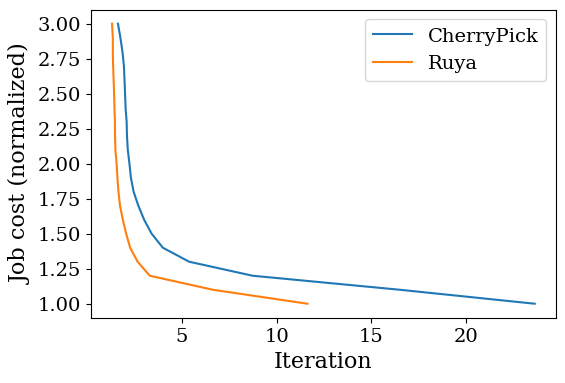

In [19]:
li_ruya = [interpret_job_results(results_ruya[job]) for job in jobs]
li_baseline = [interpret_job_results(results_baseline[job]) for job in jobs]
x_ruya = list(map(lambda x: np.array(x).mean(), list(zip(*li_ruya))))
x_baseline = list(map(lambda x: np.array(x).mean(), list(zip(*li_baseline))))

plt.figure(figsize=(6,4))
plt.plot(x_baseline, mile_stones, label="CherryPick")
plt.plot(x_ruya, mile_stones, label="Ruya")
plt.xlabel("Iteration", fontsize=16); plt.ylabel("Job cost (normalized)", fontsize=16)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.legend(fontsize=14)
plt.savefig(f'plots/job_cost_{font_family}.pdf', bbox_inches="tight"); plt.show()

In [20]:
def cost_of_random_config(job, amount):
    job_df = get_job_df(job)
    job_costs_norm = list(job_df['cost_norm'])
    return random.choices(job_costs_norm, k=amount)

In [21]:
N = 100
def get_costs(results, total_iterations):
    costs = []
    cum_costs = []
    for job in jobs:
        for config, cost in results[job]:
            explore_iterations_costs = list(cost)+list(cost_of_random_config(job, 0))
            exploit_iterations_costs = [1] * (N - len(explore_iterations_costs))
            all_iterations_costs = explore_iterations_costs+exploit_iterations_costs
            cum_costs.append([sum(all_iterations_costs[0:x]) for x in range(1, len(all_iterations_costs)+1)])
            costs.append(all_iterations_costs)
    return costs, cum_costs

costs_ruya, cum_costs_ruya  = get_costs(results_ruya, 100)
costs_baseline, cum_costs_baseline = get_costs(results_baseline, 100)

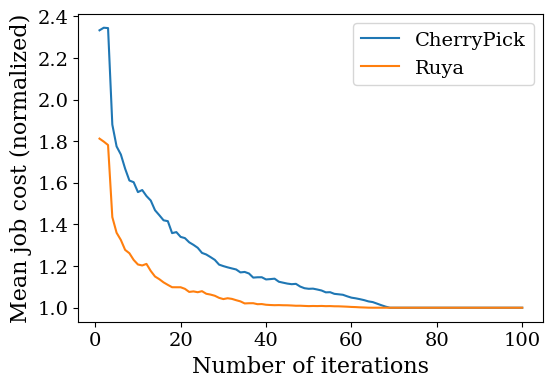

In [22]:
x = list(range(1, N+1))
y_ruya = [np.array(costs_ruya)[:,n].mean() for n in range(N)]
y_baseline = [np.array(costs_baseline)[:,n].mean() for n in range(N)]

plt.figure(figsize=(6,4))
plt.plot(x,y_baseline, label='CherryPick')
plt.plot(x,y_ruya, label='Ruya')
plt.xlabel("Number of iterations", fontsize=16)
plt.ylabel("Mean job cost (normalized)", fontsize=16)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.legend(fontsize=14)
plt.savefig(f'plots/mean_job_cost_{font_family}.pdf', bbox_inches="tight");
plt.show()

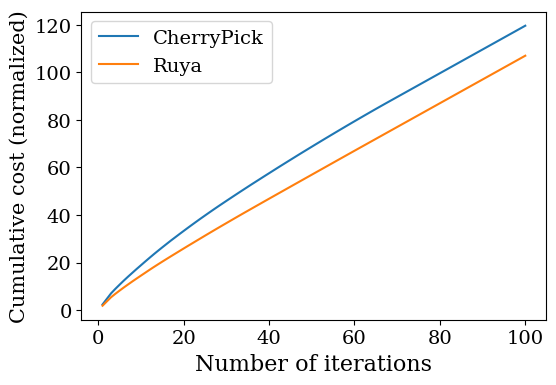

In [23]:
x = list(range(1, N+1))
y_ruya = [np.array(cum_costs_ruya)[:,n].mean() for n in range(N)]
y_baseline = [np.array(cum_costs_baseline)[:,n].mean() for n in range(N)]

plt.figure(figsize=(6,4))
plt.plot(x,y_baseline, label='CherryPick')
plt.plot(x,y_ruya, label='Ruya')
plt.xlabel("Number of iterations", fontsize=16)
plt.ylabel("Cumulative cost (normalized)", fontsize=15)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.legend(fontsize=14)
plt.savefig(f'plots/cumulative_job_cost_{font_family}.pdf', bbox_inches="tight"); plt.show()